## CS6700 PA3 - Options

`Authors: Aditya C (CS20B003), Kruthic Vignesh (CS20B045)`

### Imports and Config

In [2]:
import numpy as np
from tqdm import tqdm
import random

import gymnasium as gym

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
""" Learning parameters """

GAMMA = 0.9
ALPHA = 0.5

""" Locations of marked states in the Taxi-v3 environment """

env = gym.make("Taxi-v3")
RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC = map(
    lambda x: x[0] * 5 + x[1], env.unwrapped.locs
)
location_dict = {0: RED_LOC, 1: GREEN_LOC, 2: YELLOW_LOC, 3: BLUE_LOC}
env.close()

""" Constants for the Taxi-v3 environment """
GRID_SIZE = 25
N_PRIMITIVE_MOVES = 4
N_PRIMITIVE_ACTIONS = N_PRIMITIVE_MOVES + 2
N_OPTIONS = 4
N_TOTAL_ACTIONS = N_PRIMITIVE_ACTIONS + N_OPTIONS

### Action Selection: $\epsilon$-greedy policy

In [4]:
def epsilonGreedyPolicy(q_value_arr, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, len(q_value_arr) - 1)
    else:
        return np.argmax(q_value_arr)

### Options Framework

In [5]:
class Option:

    def __init__(
        self,
        num_positions: int,
        num_actions: int,
        terminal_position: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_value = np.zeros((num_positions, num_actions))
        self.terminal_position = terminal_position
        self.gamma = gamma
        self.alpha = alpha

    def state_to_position(self, state: int):
        return state // 20

    def get_action(self, state: int, epsilon: float = 0.1):
        """
        - state: int, the current state (0 - 499)
        - epsilon: float, the probability of selecting a random action
        """

        # The state is converted to a position in the grid since the option is agnostic to the destination and passenger locations.
        position = self.state_to_position(state)
        return epsilonGreedyPolicy(self.q_value[position], epsilon)

    def q_update(self, state: int, action: int, reward: float, next_state: int):
        """Update the Q-value of the option using the Q-learning update rule."""
        position = self.state_to_position(state)
        next_position = self.state_to_position(next_state)
        self.q_value[position, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_value[next_position])
            - self.q_value[position, action]
        )

    def check_done(self, state: int):
        """The option terminates if the agent reaches terminal position."""
        return self.state_to_position(state) == self.terminal_position

### Hierarchical Reinforcement Learning

- In HRL, we look at the problem as a hierarchy of tasks. 

- The high-level policy selects a subgoal, and the low-level policy tries to achieve that subgoal. 

- The high-level policy is trained using the options framework & Q-learning, and the low-level policy is trained using the Q-learning algorithm.

In [6]:
class HRL_Agent:

    def __init__(
        self,
        state_size: int,
        action_size: int,
        gamma: float = GAMMA,
        alpha: float = ALPHA,
    ):
        self.q_values = np.zeros((state_size, action_size))
        self.update_freq = np.zeros((state_size, action_size))
        self.gamma = gamma
        self.alpha = alpha
        self.options = []
        for loc in [RED_LOC, GREEN_LOC, YELLOW_LOC, BLUE_LOC]:
            self.options.append(Option(25, 4, loc))

    def update_primitive(self, state: int, action: int, reward: float, next_state: int):
        """Update the Q-value of the primitive action using the Q-learning update rule."""
        self.q_values[state, action] += self.alpha * (
            reward
            + self.gamma * np.max(self.q_values[next_state])
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [7]:
class SMDP_Agent(HRL_Agent):

    def __init__(self, state_size, action_size, gamma=GAMMA, alpha=ALPHA):
        super().__init__(state_size, action_size, gamma, alpha)

    def update_option_midway(self, *args, **kwargs):
        """ There is no midway update for SMDP agents."""
        return

    def update_option_once(
        self, state: int, action: int, reward: float, next_state: int, opt_duration: int
    ):
        """ At the end of the option, update Q(option_start_state, option)"""
        self.q_values[state, action] += self.alpha * (
            reward
            + (self.gamma**opt_duration) * np.max(self.q_values[next_state])
            - self.q_values[state, action]
        )
        self.update_freq[state, action] += 1

In [8]:
class IOQL_Agent(HRL_Agent):

    def __init__(self, state_size, action_size, gamma=GAMMA, alpha=ALPHA):
        super().__init__(state_size, action_size, gamma, alpha)

    def update_option_midway(
        self,
        option: int,
        state: int,
        action: int,
        reward: float,
        next_state: int,
        done: bool,
    ):
        # Update primitive action's Q-value for current state
        self.update_primitive(state, action, reward, next_state)

        # Update option's Q-value for current state
        next_val = (
            done * np.max(self.q_values[next_state])
            + (1 - done) * self.q_values[next_state, option]
        )
        self.q_values[state, option] += self.alpha * (
            reward + self.gamma * next_val - self.q_values[state, option]
        )
        self.update_freq[state, option] += 1

    def update_option_once(self, *args, **kwargs):
        """There is no end-of-option update for IOQL agents."""
        return

In [9]:
class Trainer:
    """ Brings together the environment and the agent to train the agent."""

    def __init__(self, env: gym.Env, agent: HRL_Agent):
        self.env = env
        self.agent = agent
        self.scores_arr = []

    def train(self, num_episodes: int = 1):
        """ Train the agent for a fixed number of episodes."""
        
        self.scores_arr = []
        epsilon = 0.1

        for episode in tqdm(range(num_episodes)):

            state, _ = self.env.reset()
            done = False
            total_reward = 0
            total_duration = 0
            
            # pickup_indx, dropoff_indx = (state % 20) // 4, state % 4
            # pickup_loc, dropoff_loc = location_dict[pickup_indx], location_dict[dropoff_indx]

            epsilon = max(0.01, epsilon * 0.9975)

            # while episode is not over
            while not done:

                # choose action
                arr = self.agent.q_values[state][4:]
                action = epsilonGreedyPolicy(arr, epsilon=epsilon) + 4
                # action = epsilonGreedyPolicy(self.agent.q_values[state])

                """ Primitive actions - South, North, East, West, Pickup, Dropoff """
                if action < 6:
                    next_state, reward, is_terminal, is_trunc, _ = self.env.step(action)
                    done = is_terminal or is_trunc
                    total_reward += reward
                    self.agent.update_primitive(state, action, reward, next_state)
                    state = next_state

                else:
                    """ Options - Go to Red, Green, Yellow, Blue """
                    opt_start_state, opt_id = state, action - 6
                    opt_reward, opt_duration = 0, 0
                    opt_done = self.agent.options[opt_id].check_done(state)

                    if opt_done:
                        continue
                        
                    """ Execute option """
                    while not opt_done and not done:

                        # choose action
                        opt_action = self.agent.options[opt_id].get_action(state, epsilon=epsilon)

                        # take action
                        next_state, reward, is_terminal, is_trunc, _ = self.env.step(opt_action)
                        done = is_terminal or is_trunc
                        total_reward += reward
                        opt_reward += reward * (self.agent.gamma**opt_duration)

                        # update option's q-values
                        self.agent.options[opt_id].q_update(state, opt_action, reward, next_state)
                        
                        # update q-values of agent
                        opt_done = self.agent.options[opt_id].check_done(next_state)
                        self.agent.update_option_midway(
                                action, state, opt_action, reward, next_state, (done or opt_done)
                        )

                        # update variables
                        opt_duration += 1
                        state = next_state

                    """ End of option - update q-values """
                    # for SMDP Q-Learning
                    self.agent.update_option_once(
                        opt_start_state, action, opt_reward, next_state, opt_duration
                    )

                """ If episode is over, append total reward """
                if done:
                    self.scores_arr.append(total_reward)
                
        return self.scores_arr


    def plot_scores(self):
        """ Plot score array of the agent """
        
        # aggregate every 5 elements for smoother plot
        scores_arr = np.array(self.scores_arr)
        scores_arr = scores_arr[: len(scores_arr) // 5 * 5].reshape(
            -1, 5
        )
        scores_arr = scores_arr.mean(axis=1)

        plt.figure(figsize=(10, 5))
        x_vals = np.arange(5, len(scores_arr) * 5 + 5, 5)
        plt.plot(x_vals, scores_arr)

        max_score = np.max(self.scores_arr)
        min_score = np.min(self.scores_arr)
        mean_score = round(np.mean(self.scores_arr), 2)

        plt.hlines(max_score, 0, 5 * len(scores_arr), colors="g", linestyles="--")
        plt.hlines(mean_score, 0, 5 * len(scores_arr), colors="b", linestyles="--")

        # annotate the max, min and mean scores
        plt.annotate(f"Max: {max_score}", (0, max_score-30), color="g")
        plt.annotate(f"Mean: {mean_score}", (5 * len(scores_arr) - 150, mean_score-30), color="b")
        
        plt.xlabel("Episode number")
        plt.ylabel("Total reward")
        plt.title("(Undiscounted) Episodic reward over time")
        
        print(f"Max score: {max_score}, Min score: {min_score}, Mean score: {mean_score}")
        print("Mean over last 200 episodes: ", np.mean(self.scores_arr[-200:]))

        plt.show()

In [10]:
# agent = SMDP_QLearning(500, 10)
agent = IOQL_Agent(500, 10)
trainer = Trainer(env, agent)
score_list = trainer.train(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:03<00:00, 311.61it/s]


Max score: 15, Min score: -425, Mean score: -66.18
Mean over last 200 episodes:  -13.37


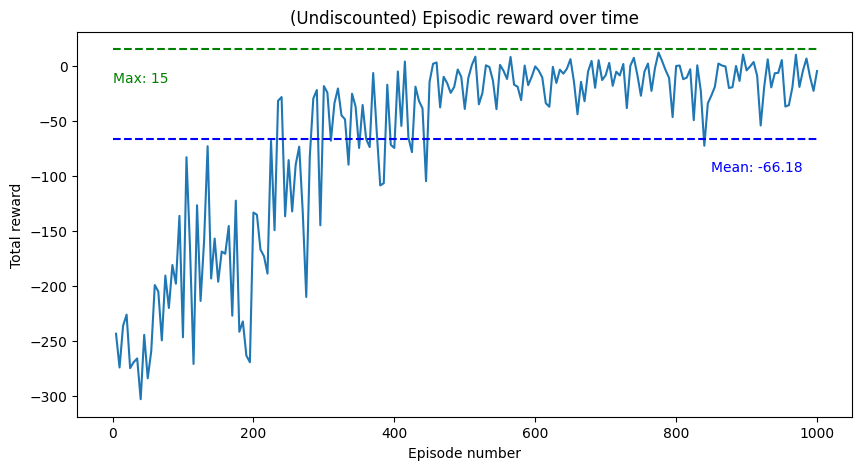

In [11]:
trainer.plot_scores()

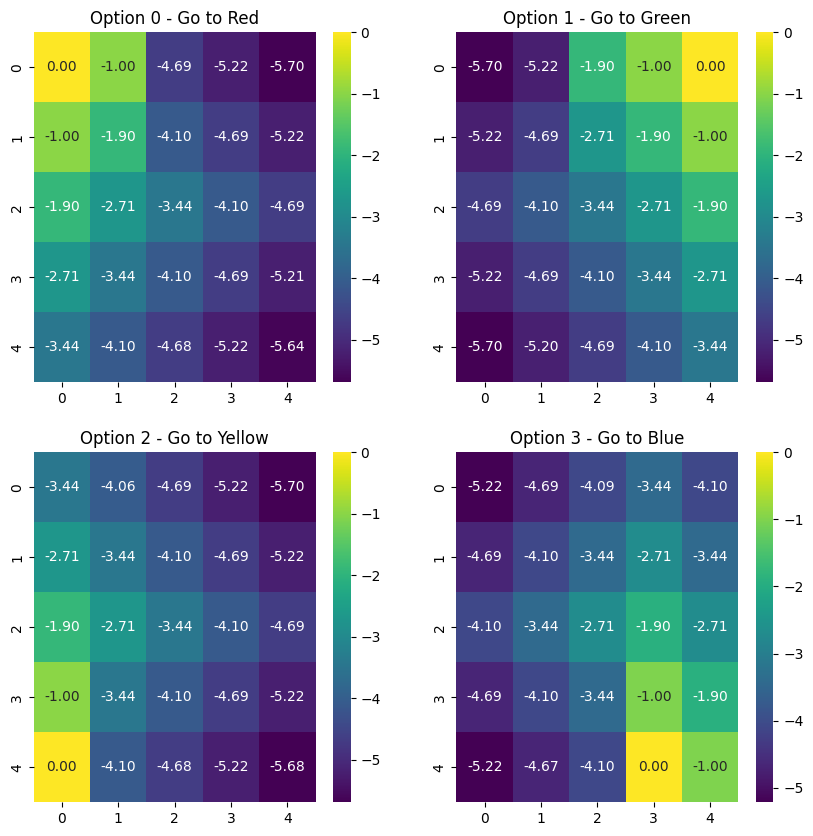

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

grid = np.zeros((4, 5, 5))
for i in range(4):
    grid[i] = np.max(agent.options[i].q_value, axis=1).reshape(5, 5)
    sns.heatmap(grid[i], ax=ax[i // 2, i % 2], annot=True, fmt=".2f", cmap="viridis")
    ax[i // 2, i % 2].set_title(
        f"Option {i} - Go to {['Red', 'Green', 'Yellow', 'Blue'][i]}"
    )

plt.show()

In [13]:
dict = {
    0: "↓",
    1: "↑",
    2: "→",
    3: "←",
    4: "Pickup",
    5: "Dropoff",
    6: "Red",
    7: "Green",
    8: "Yellow",
    9: "Blue",
}

Destination: Red


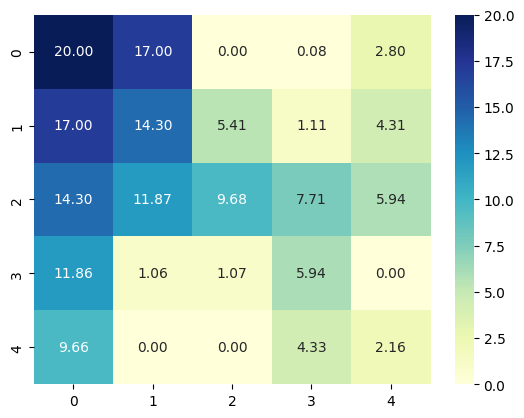

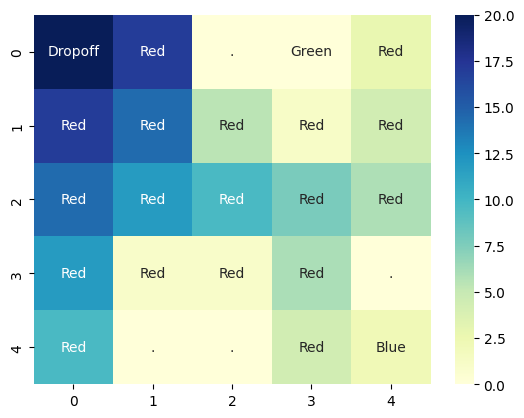

Destination: Green


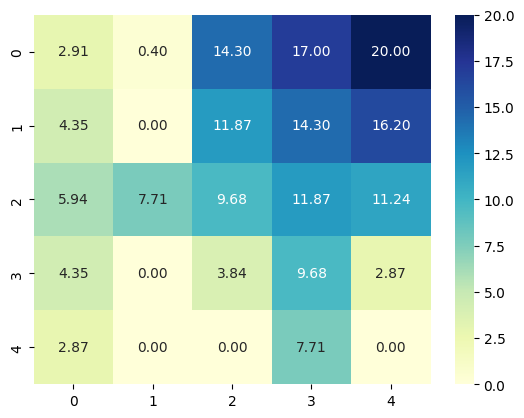

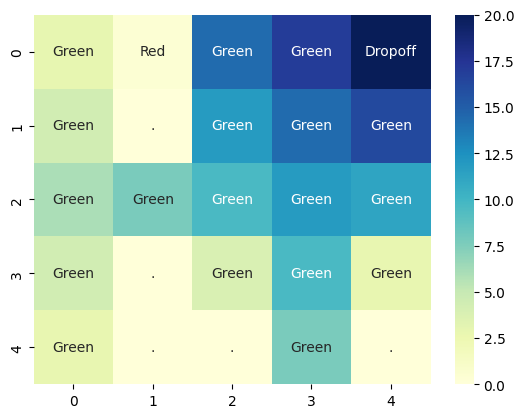

Destination: Yellow


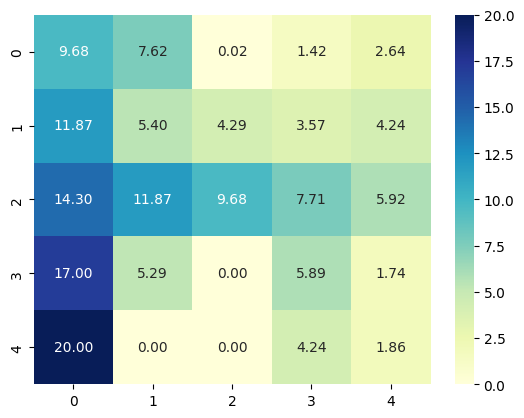

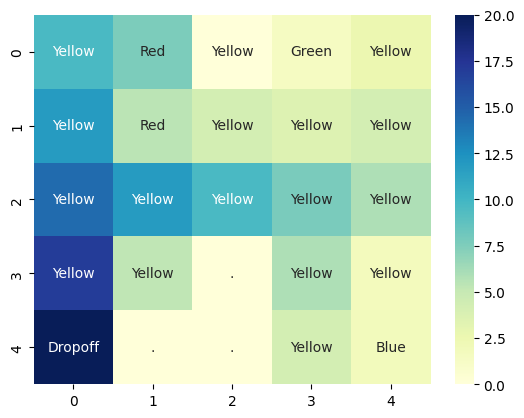

Destination: Blue


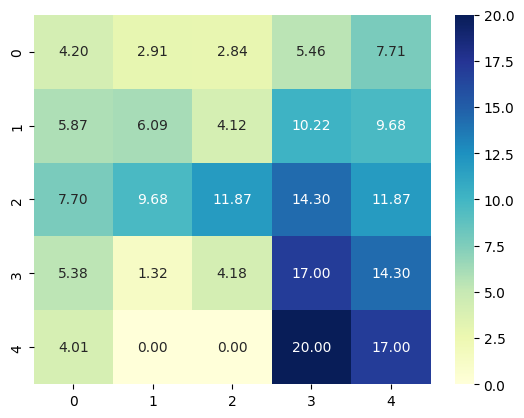

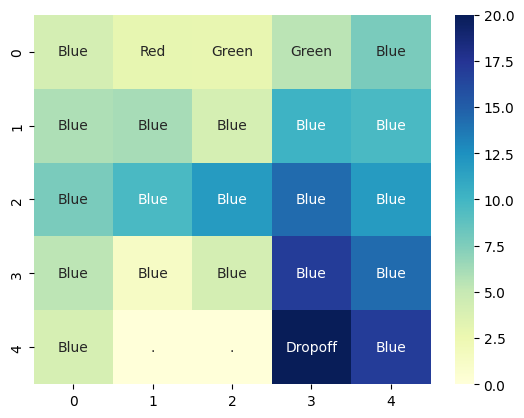

In [24]:
# select every 4th row of q_values and put it into a grid

# desination fixed to be red
for dest in range(4):

    print(f"Destination: {['Red', 'Green', 'Yellow', 'Blue'][dest]}")
    grid = trainer.agent.q_values[dest::4]
    grid2 = trainer.agent.q_values[dest::4]
    upd_grid = trainer.agent.update_freq[dest::4]

    # passenger is inside car
    grid = grid[4::5]
    grid2 = grid2[4::5]
    upd_grid = upd_grid[4::5]

    # grid = grid[:, 6].reshape(5, 5)
    grid = np.max(grid[:,4:], axis=1).reshape(5, 5)
    grid3 = np.argmax(grid2[:,4:], axis=1) + 4
    grid4 = np.max(grid2[:,4:], axis=1).reshape(5, 5)
    upd_grid = np.sum(upd_grid[:,4:], axis=1).reshape(5, 5)

    grid3 = [dict[i] for i in grid3]
    grid3 = np.array(list(grid3)).reshape(5, 5)
    # plot the grid
    sns.heatmap(grid, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.show()

    for i in range(5):
        for j in range(5):
            if upd_grid[i][j] <= 1 or grid4[i][j] <= 0:
                grid3[i][j] = "."

    # print grid2 with row and column labels, I dont want heatmap of grid2
    sns.heatmap(grid4, annot=grid3, fmt="s", cmap="YlGnBu")
    plt.show()

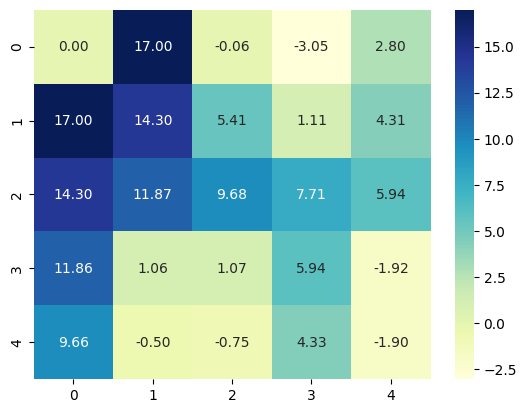

[['Dropoff' '←' '↓' '↓' '↓']
 ['↑' '↑' '↓' '↓' '↓']
 ['↑' '↑' '←' '←' '←']
 ['↑' '↑' '↑' '↑' '←']
 ['↑' '↓' '↓' '↑' 'Blue']]


In [15]:
# select every 4th row of q_values and put it into a grid

# desination fixed to be red
grid = trainer.agent.q_values[::4]
grid2 = trainer.agent.q_values[::4]

# passenger is inside car
grid = grid[4::5]
grid2 = grid2[4::5]

grid = grid[:, 6].reshape(5, 5)
grid2 = np.argmax(grid2, axis=1)

grid2 = [dict[i] for i in grid2]
grid2 = np.array(list(grid2)).reshape(5, 5)
# plot the grid
sns.heatmap(grid, annot=True, fmt=".2f", cmap="YlGnBu")
plt.show()

# print grid2 with row and column labels, I dont want heatmap of grid2
print(grid2)

In [16]:
st = (4 * 5 + 4) * 4 + 0
print([round(i, 2) for i in trainer.agent.q_values[st]] )
print([int(i) for i in trainer.agent.update_freq[st]])

[2.91, 0.56, 0.0, 1.27, -8.48, -0.16, 2.8, 0.0, -2.47, -3.26]
[94, 2, 0, 8, 12, 15, 81, 0, 9, 14]


In [17]:
st = (0 * 5 + 4) * 4 + 0
trainer.agent.q_values[st]

array([12.2210805 ,  0.        ,  6.89838982,  0.        ,  0.9375    ,
       20.        ,  0.        , -0.75      ,  0.        , -1.20125   ])